# 12 Features: ['Z','N','A','A^2/3','(N-Z)/A','PF','Zeo','NEO','Delta_Z','Delta_N','Shell_P','Shell_N']  

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm

from sklearn import tree
from sklearn import neighbors
from sklearn.impute import SimpleImputer

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic


from sklearn.model_selection import cross_val_score, KFold

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn import linear_model
from sklearn import ensemble 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.neighbors import KNeighborsRegressor


from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score


/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
cwd = os.getcwd()

# Read and Scale the Data

In [4]:
train_data = pd.read_excel (r'training_fixed.xlsx') 

name=['Z','N','A','A^2/3','(N-Z)/A','PF','Zeo','NEO','Delta_Z','Delta_N','Shell_P','Shell_N']  

x_train = pd.DataFrame(train_data,  columns=name)  
y_train = pd.DataFrame(train_data, columns= ['MeV'])

test_size = 0.70  # You can adjust this to set the proportion of the test set
random_state = 100  # You can choose any random_state value for reproducibility

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, random_state=random_state)

train_len=len(x_train)
test_len=len(x_test)


extra_data= pd.read_excel (r'NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx')
x_extra = pd.DataFrame(extra_data,  columns=name)  
y_extra = pd.DataFrame(extra_data, columns= ['MeV'])

inp=np.concatenate((x_train,x_test,x_extra),axis=0)
out=np.concatenate((y_train,y_test,y_extra),axis=0)
train_test_len=train_len+test_len

# Handle missing values
imputer = SimpleImputer(strategy='mean')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)
x_extra = imputer.transform(x_extra)

##################################
## scale
##################################
# Initialize the StandardScaler for input data
sc_X = StandardScaler()

# Fit the scaler on the training data
sc_X.fit(x_train)

# Transform the training and testing data using the fitted scaler
x_train = sc_X.transform(x_train)
x_test = sc_X.transform(x_test)
x_extra = sc_X.transform(x_extra)

# Initialize the StandardScaler for output data
sc_Y = StandardScaler()

# Fit the scaler on the training data
sc_Y.fit(y_train)

# Transform the training and testing data using the fitted scaler
y_train = sc_Y.transform(y_train)
y_test = sc_Y.transform(y_test)
y_extra = sc_Y.transform(y_extra)

# For input data
print("Input Data:")
print("Mean:", sc_X.mean_)
print("Standard Deviation:", sc_X.scale_)

# For output data
print("\nOutput Data:")
print("Mean:", sc_Y.mean_)
print("Standard Deviation:", sc_Y.scale_)
################################
name+=['original','prediction']

Input Data:
Mean: [ 56.71328671  79.04755245 135.76083916  25.68988113   0.15039668
   3.02585192   0.46713287   0.51888112   6.20979021   9.01118881
   1.62097902   2.23916084]
Standard Deviation: [24.70939415 38.28400282 62.61852653  8.51074269  0.07373895  2.37338797
  0.49891858  0.49964338  4.55986312  6.49646601  0.96097657  1.18622837]

Output Data:
Mean: [-40.76148206]
Standard Deviation: [42.44917003]


In [5]:
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-09] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name + "\n")
            wfile.write(f"Scale: {s} Alpha: {a} Normalize: {n}\n")
            wfile.write("----------------------------------\n")
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-4, 1e5)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel, alpha=a, normalize_y=n).fit(x_train, y_train)
            
            score = gpr.score(x_train, y_train)
            print("R^2 Score:", score)
            
            pred_train = gpr.predict(x_train).reshape(-1, 1)
            pred = gpr.predict(x_test).reshape(-1, 1)
            pred_extra = gpr.predict(x_extra).reshape(-1, 1)
            
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)
            pred_train_mean = pred_train_mean.reshape(-1, 1)
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)
            
            data = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train)), axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
            
            data = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred)), axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            
            data = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra)), axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std) - sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std) - sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std) - sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write(f"rms_train={rmse_train:.4f}, rms_pred={rmse:.4f}, rms_extra={rms_extra:.4f}\n")
            print(rmse_train, rmse, rms_extra)

wfile.close()
os.chdir(cwd)

R^2 Score: 0.9999790238561262
0.19441601178546772 0.6370161766313864 nan


# Kernel Function 1: RBF + White

## Range of all parameters
1. length scale = (1e-4, 1e5) or (1e-4, 1e2) or ((1e-4, 1e8) 
2. noise level = (1e-10, 1e1) or (1e-10, 1e2) or  (1e-10, 1e-2)
3. alpha = 1e-09 or 1e-10 or 1e-11

## Use Grid to Find out the best group of parameters


In [8]:
# Run and Print all the results
# Find out the best group
import itertools
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Define the parameter grid
length_scales_bounds = [(1e-4, 1e5), (1e-4, 1e2), (1e-4, 1e8)]
noise_levels_bounds = [(1e-10, 1e1), (1e-10, 1e2), (1e-10, 1e-2)]
alphas = [1e-9, 1e-10, 1e-11]

# Create a list of all combinations of parameters
param_grid = list(itertools.product(length_scales_bounds, noise_levels_bounds, alphas))

# Function to create and evaluate a GaussianProcessRegressor with given parameters
def evaluate_gpr(params):
    length_scale_bounds, noise_level_bounds, alpha = params
    kernel = RBF(length_scale=s, length_scale_bounds=length_scale_bounds) + WhiteKernel(noise_level=1.0, noise_level_bounds=noise_level_bounds)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=42)
    gpr.fit(x_train, y_train)
    y_pred_train = gpr.predict(x_train)
    y_pred_test = gpr.predict(x_test)
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2 = r2_score(y_test, y_pred_test)
    
    return mse_train, mse_test, rmse_train, rmse_test, r2

# Perform the grid search
results = []
for params in param_grid:
    mse_train, mse_test, rmse_train, rmse_test, r2 = evaluate_gpr(params)
    results.append((params, mse_train, mse_test, rmse_train, rmse_test, r2))

# Find the best parameters
best_params, best_mse_train, best_mse_test, best_rmse_train, best_rmse_test, best_r2 = min(results, key=lambda x: x[2])

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Parameters', 'MSE Train', 'MSE Test', 'RMSE Train', 'RMSE Test', 'R2'])

# Set display precision for more decimal places
pd.set_option("display.precision", 15)

# Display the results
print("Grid Search Results:")
print(results_df)
print("\nBest Parameters:")
print(best_params)
print("Best R2 Score:")
print(f"{best_r2:.15f}")
print("Best RMSE Train, Test:")
print(f"{best_rmse_train:.15f}", f"{best_rmse_test:.15f}")

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with

Grid Search Results:
                                        Parameters             MSE Train  \
0       ((0.0001, 100000.0), (1e-10, 10.0), 1e-09)    87.805536481006172   
1       ((0.0001, 100000.0), (1e-10, 10.0), 1e-10)    87.805536477099210   
2       ((0.0001, 100000.0), (1e-10, 10.0), 1e-11)    87.805536476708824   
3      ((0.0001, 100000.0), (1e-10, 100.0), 1e-09)   240.357795779365688   
4      ((0.0001, 100000.0), (1e-10, 100.0), 1e-10)   240.357795778261647   
5      ((0.0001, 100000.0), (1e-10, 100.0), 1e-11)   240.357795778151285   
6       ((0.0001, 100000.0), (1e-10, 0.01), 1e-09)     0.108780328414622   
7       ((0.0001, 100000.0), (1e-10, 0.01), 1e-10)     0.108780320254374   
8       ((0.0001, 100000.0), (1e-10, 0.01), 1e-11)     0.108780319438348   
9          ((0.0001, 100.0), (1e-10, 10.0), 1e-09)    87.805537944458663   
10         ((0.0001, 100.0), (1e-10, 10.0), 1e-10)    87.805537940553023   
11         ((0.0001, 100.0), (1e-10, 10.0), 1e-11)    87.8055379401

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


### Best parameters group for RBF + White: ((0.0001, 100.0), (1e-10, 100.0), 1e-11)

## Based on the Best parameters group, change the ratio size
### Test size= 0.2, 0.3, 0.4, 0.5, 0.6

In [11]:
# Load the train data
train_data = pd.read_excel (r'training_fixed.xlsx') 

name=['Z','N','A','A^2/3','(N-Z)/A','PF','Zeo','NEO','Delta_Z','Delta_N','Shell_P','Shell_N']  


x_train = pd.DataFrame(train_data, columns=name)
y_train = pd.DataFrame(train_data, columns=['MeV'])

# Load extra data
extra_data = pd.read_excel(r'NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx')
x_extra = pd.DataFrame(extra_data, columns=name)
y_extra = pd.DataFrame(extra_data, columns=['MeV'])

# Define different test sizes
test_sizes = [0.2, 0.3, 0.4, 0.5, 0.6]

for test_size in test_sizes:
    print(f"Processing with test size: {test_size}")
    
    # Split the data into training and testing sets
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
        x_train, y_train, test_size=test_size, random_state=100
    )
    
    train_len = len(x_train_split)
    test_len = len(x_test_split)
    
    # Initialize the StandardScaler for input data
    sc_X = StandardScaler()

    # Fit the scaler on the training data
    sc_X.fit(x_train_split)

    # Transform the training, testing, and extra data using the fitted scaler
    x_train_scaled = sc_X.transform(x_train_split)
    x_test_scaled = sc_X.transform(x_test_split)
    x_extra_scaled = sc_X.transform(x_extra)

    # Initialize the StandardScaler for output data
    sc_Y = StandardScaler()

    # Fit the scaler on the training data
    sc_Y.fit(y_train_split)

    # Transform the training, testing, and extra data using the fitted scaler
    y_train_scaled = sc_Y.transform(y_train_split)
    y_test_scaled = sc_Y.transform(y_test_split)
    y_extra_scaled = sc_Y.transform(y_extra)

    # Print the scaling information
    print("Input Data:")
    print("Mean:", sc_X.mean_)
    print("Standard Deviation:", sc_X.scale_)

    print("\nOutput Data:")
    print("Mean:", sc_Y.mean_)
    print("Standard Deviation:", sc_Y.scale_)

    # Model training and analysis
    os.chdir(cwd)
    analyze_name = "GP_Regression"
    if not os.path.exists(f"./{analyze_name}"):
        os.makedirs(f"./{analyze_name}")
    os.chdir(f"./{analyze_name}")
    wfile = open(f"results_{analyze_name}_selected.txt", "a")
    
    Scale = [1.0]
    Alpha = [1e-11]
    Normalize = [False]

    for s in Scale:
        for a in Alpha:
            for n in Normalize:
                wfile.write(f"{analyze_name}\n")
                wfile.write(f"Scale : {s} Alpha: {a} Normalize: {n} Test Size: {test_size}\n")
                wfile.write("----------------------------------\n")
                
                kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(0.0001, 100.0)) + \
                         WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 100.0))
                gpr = GaussianProcessRegressor(kernel=kernel, alpha=a, normalize_y=n).fit(x_train_scaled, y_train_scaled)

                score = gpr.score(x_train_scaled, y_train_scaled)
                print("R^2 Score:", score)

                pred_train = gpr.predict(x_train_scaled).reshape(-1, 1)
                pred = gpr.predict(x_test_scaled).reshape(-1, 1)
                pred_extra = gpr.predict(x_extra_scaled).reshape(-1, 1)

                pred_train_mean, pred_train_std = gpr.predict(x_train_scaled, return_std=True)
                pred_mean, pred_std = gpr.predict(x_test_scaled, return_std=True)
                pred_extra_mean, pred_extra_std = gpr.predict(x_extra_scaled, return_std=True)

                data_train = np.concatenate((sc_X.inverse_transform(x_train_scaled), sc_Y.inverse_transform(y_train_scaled), sc_Y.inverse_transform(pred_train)), axis=1)
                dfw_train = pd.DataFrame(data_train)
                dfw_train.to_excel('Train_data_predictions.xlsx', index=False, header=name + ['original', 'prediction'])
                
                data_test = np.concatenate((sc_X.inverse_transform(x_test_scaled), sc_Y.inverse_transform(y_test_scaled), sc_Y.inverse_transform(pred)), axis=1)
                dfw_test = pd.DataFrame(data_test)
                dfw_test.to_excel('predictions.xlsx', index=False, header=name + ['original', 'prediction'])
                
                data_extra = np.concatenate((sc_X.inverse_transform(x_extra_scaled), sc_Y.inverse_transform(y_extra_scaled), sc_Y.inverse_transform(pred_extra)), axis=1)
                dfw_extra = pd.DataFrame(data_extra)
                dfw_extra.to_excel('extrapolation.xlsx', index=False, header=name + ['original', 'prediction'])
                
                mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train_scaled) - sc_Y.inverse_transform(pred_train))) / np.size(y_train_scaled)
                rmse_train = np.sqrt(mse_train)

                mse = np.sum(np.square(sc_Y.inverse_transform(y_test_scaled) - sc_Y.inverse_transform(pred))) / np.size(y_test_scaled)
                rmse = np.sqrt(mse)

                ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra_scaled) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra_scaled)
                rms_extra = np.sqrt(ms_extra)

                wfile.write(f"rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n" % (rmse_train, rmse, rms_extra))
                print(rmse_train, rmse, rms_extra)

    wfile.close()
    os.chdir(cwd)

Processing with test size: 0.2
Input Data:
Mean: [ 57.1975891   79.77777778 136.97536688  25.86887333   0.15163836
   3.02816209   0.471174     0.49161426   6.27410901   8.92138365
   1.63259958   2.24737945]
Standard Deviation: [24.55826201 37.92052664 62.07984918  8.4124406   0.07330345  2.39882469
  0.49916837  0.49992967  4.59671523  6.55112964  0.95590746  1.18455223]

Output Data:
Mean: [-40.42893003]
Standard Deviation: [42.04066295]
R^2 Score: 0.9999905979939381
0.1289079848297278 0.2620204973053876 nan
Processing with test size: 0.3
Input Data:
Mean: [ 57.48323353  80.18682635 137.67005988  25.96152917   0.15161144
   3.05355524   0.46886228   0.48742515   6.31556886   8.97005988
   1.64371257   2.26047904]
Standard Deviation: [24.55716819 37.9156305  62.07075933  8.40644008  0.0733222   2.38977257
  0.4990295   0.49984185  4.5830131   6.53257627  0.95434995  1.18212526]

Output Data:
Mean: [-40.08641801]
Standard Deviation: [42.13144207]


/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


R^2 Score: 0.9999864873551632
0.1548732832784864 0.3083082026111756 nan
Processing with test size: 0.4
Input Data:
Mean: [ 57.57512229  80.21663173 137.79175402  25.98588518   0.15063681
   3.06218929   0.47239693   0.49475891   6.35918938   9.0118798
   1.64640112   2.26275332]
Standard Deviation: [24.43648156 37.78841425 61.82343348  8.36100388  0.07366021  2.40608908
  0.49923749  0.49997253  4.60754529  6.56264752  0.94985341  1.17367013]

Output Data:
Mean: [-40.35911008]
Standard Deviation: [42.23861824]
R^2 Score: 0.9999803400313372
0.1872841883542013 0.42325169432724186 nan
Processing with test size: 0.5
Input Data:
Mean: [ 57.93545683  80.75775356 138.69321039  26.0986096    0.15036833
   3.04428201   0.4635373    0.49958089   6.29589271   9.0293378
   1.6605197    2.28499581]
Standard Deviation: [24.47976789 37.95209173 62.03254503  8.3928535   0.07430411  2.40101675
  0.4986687   0.49999982  4.59969658  6.58378034  0.95300754  1.17856713]

Output Data:
Mean: [-39.83628956]
S

### Overfitting Check

Overfitting: Yes


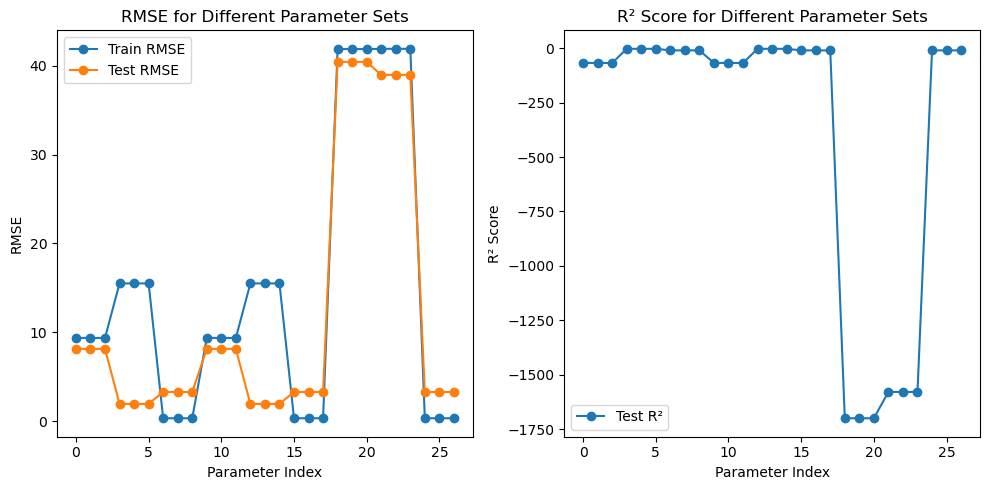

In [13]:
##### Overfitting Check #####
###### NEED TO FIX ######

# Check for overfitting
overfitting_detected = False
threshold = 0.10  # 10% difference threshold

for _, mse_train, mse_test, rmse_train, rmse_test, r2 in results:
    if abs(rmse_train - rmse_test) / rmse_train > threshold:
        overfitting_detected = True
        break

# Print whether overfitting is detected
if overfitting_detected:
    print("Overfitting: Yes")
else:
    print("Overfitting: No")

# Visualization
plt.figure(figsize=(10, 5))

# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(results_df['RMSE Train'], label='Train RMSE', marker='o')
plt.plot(results_df['RMSE Test'], label='Test RMSE', marker='o')
plt.xlabel('Parameter Index')
plt.ylabel('RMSE')
plt.title('RMSE for Different Parameter Sets')
plt.legend()

# Plot R² Score
plt.subplot(1, 2, 2)
plt.plot(results_df['R2'], label='Test R²', marker='o')
plt.xlabel('Parameter Index')
plt.ylabel('R² Score')
plt.title('R² Score for Different Parameter Sets')
plt.legend()

plt.tight_layout()
plt.show()


# Kernel Function 2: Matérn + White

## Range of all parameters
1. length scale = (1e-4, 1e5) or (1e-4, 1e2) or ((1e-4, 1e8) 
2. noise level = (1e-10, 1e1) or (1e-10, 1e2) or  (1e-10, 1e-2)
3. alpha = 1e-09 or 1e-10 or 1e-11
4. nu = 0.5, 1.5, 2.5

## Use Grid to Find out the best group of parameters


In [14]:
# Define the parameter grid
length_scales_bounds = [(1e-4, 1e5), (1e-4, 1e2), (1e-4, 1e8)]
noise_levels_bounds = [(1e-10, 1e1), (1e-10, 1e2), (1e-10, 1e-2)]
alphas = [1e-9, 1e-10, 1e-11]
nus = [0.5, 1.5, 2.5]

# Create a list of all combinations of parameters
param_grid = list(itertools.product(length_scales_bounds, noise_levels_bounds, alphas, nus))

# Function to create and evaluate a GaussianProcessRegressor with given parameters
def evaluate_gpr(params):
    length_scale_bounds, noise_level_bounds, alpha, nu = params
    kernel = Matern(length_scale=s, length_scale_bounds=length_scale_bounds, nu=nu) + WhiteKernel(noise_level=1.0, noise_level_bounds=noise_level_bounds)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=42)
    gpr.fit(x_train, y_train)
    y_pred_train = gpr.predict(x_train)
    y_pred_test = gpr.predict(x_test)
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2 = r2_score(y_test, y_pred_test)
    
    return mse_train, mse_test, rmse_train, rmse_test, r2

# Perform the grid search
results = []
for params in param_grid:
    mse_train, mse_test, rmse_train, rmse_test, r2 = evaluate_gpr(params)
    results.append((params, mse_train, mse_test, rmse_train, rmse_test, r2))

# Find the best parameters
best_params, best_mse_train, best_mse_test, best_rmse_train, best_rmse_test, best_r2 = min(results, key=lambda x: x[2])

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Parameters', 'MSE Train', 'MSE Test', 'RMSE Train', 'RMSE Test', 'R2'])

# Set display precision for more decimal places
pd.set_option("display.precision", 15)

# Display the results
print("Grid Search Results:")
print(results_df)
print("\nBest Parameters:")
print(best_params)
print("Best R2 Score:")
print(f"{best_r2:.15f}")
print("Best RMSE Train, Test:")
print(f"{best_rmse_train:.15f}", f"{best_rmse_test:.15f}")


/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted wi

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with

KeyboardInterrupt: 

### Best parameters group for Matérn + White: ((0.0001, 100000.0), (1e-10, 10.0), 1e-10, 2.5)

## Based on the Best parameters group, change the ratio size
### Test size= 0.2, 0.3, 0.4, 0.5, 0.6

In [20]:
# Load the train data
train_data = pd.read_excel (r'training_fixed.xlsx') 

name=['Z','N','A','A^2/3','(N-Z)/A','PF','Zeo','NEO','Delta_Z','Delta_N','Shell_P','Shell_N']  

x_train = pd.DataFrame(train_data, columns=name)
y_train = pd.DataFrame(train_data, columns=['MeV'])

# Load extra data
extra_data = pd.read_excel(r'NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx')
x_extra = pd.DataFrame(extra_data, columns=name)
y_extra = pd.DataFrame(extra_data, columns=['MeV'])

# Define different test sizes
test_sizes = [0.2, 0.3, 0.4, 0.5, 0.6]

for test_size in test_sizes:
    print(f"Processing with test size: {test_size}")
    
    # Split the data into training and testing sets
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
        x_train, y_train, test_size=test_size, random_state=100
    )
    
    train_len = len(x_train_split)
    test_len = len(x_test_split)
    
    # Initialize the StandardScaler for input data
    sc_X = StandardScaler()

    # Fit the scaler on the training data
    sc_X.fit(x_train_split)

    # Transform the training, testing, and extra data using the fitted scaler
    x_train_scaled = sc_X.transform(x_train_split)
    x_test_scaled = sc_X.transform(x_test_split)
    x_extra_scaled = sc_X.transform(x_extra)

    # Initialize the StandardScaler for output data
    sc_Y = StandardScaler()

    # Fit the scaler on the training data
    sc_Y.fit(y_train_split)

    # Transform the training, testing, and extra data using the fitted scaler
    y_train_scaled = sc_Y.transform(y_train_split)
    y_test_scaled = sc_Y.transform(y_test_split)
    y_extra_scaled = sc_Y.transform(y_extra)

    # Print the scaling information
    print("Input Data:")
    print("Mean:", sc_X.mean_)
    print("Standard Deviation:", sc_X.scale_)

    print("\nOutput Data:")
    print("Mean:", sc_Y.mean_)
    print("Standard Deviation:", sc_Y.scale_)

    # Model training and analysis
    os.chdir(cwd)
    analyze_name = "GP_Regression"
    if not os.path.exists(f"./{analyze_name}"):
        os.makedirs(f"./{analyze_name}")
    os.chdir(f"./{analyze_name}")
    wfile = open(f"results_{analyze_name}_selected.txt", "a")

    Scale = [1.0]
    Alpha = [1e-10]
    Normalize = [False]

    for s in Scale:
        for a in Alpha:
            for n in Normalize:
                wfile.write(f"{analyze_name}\n")
                wfile.write(f"Scale : {s} Alpha: {a} Normalize: {n} Test Size: {test_size}\n")
                wfile.write("----------------------------------\n")
            
                kernel = 1.0 * Matern(length_scale=s, length_scale_bounds=(0.0001, 100000.0), nu=2.5) + \
                         WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 10.0))
                gpr = GaussianProcessRegressor(kernel=kernel, alpha=a, normalize_y=n).fit(x_train_scaled, y_train_scaled)

                score = gpr.score(x_train_scaled, y_train_scaled)
                print("R^2 Score:", score)

                pred_train = gpr.predict(x_train_scaled).reshape(-1, 1)
                pred = gpr.predict(x_test_scaled).reshape(-1, 1)
                pred_extra = gpr.predict(x_extra_scaled).reshape(-1, 1)

                pred_train_mean, pred_train_std = gpr.predict(x_train_scaled, return_std=True)
                pred_mean, pred_std = gpr.predict(x_test_scaled, return_std=True)
                pred_extra_mean, pred_extra_std = gpr.predict(x_extra_scaled, return_std=True)

                data_train = np.concatenate((sc_X.inverse_transform(x_train_scaled), sc_Y.inverse_transform(y_train_scaled), sc_Y.inverse_transform(pred_train)), axis=1)
                dfw_train = pd.DataFrame(data_train)
                dfw_train.to_excel('Train_data_predictions.xlsx', index=False, header=name + ['original', 'prediction'])
            
                data_test = np.concatenate((sc_X.inverse_transform(x_test_scaled), sc_Y.inverse_transform(y_test_scaled), sc_Y.inverse_transform(pred)), axis=1)
                dfw_test = pd.DataFrame(data_test)
                dfw_test.to_excel('predictions.xlsx', index=False, header=name + ['original', 'prediction'])
            
                data_extra = np.concatenate((sc_X.inverse_transform(x_extra_scaled), sc_Y.inverse_transform(y_extra_scaled), sc_Y.inverse_transform(pred_extra)), axis=1)
                dfw_extra = pd.DataFrame(data_extra)
                dfw_extra.to_excel('extrapolation.xlsx', index=False, header=name + ['original', 'prediction'])
            
                mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train_scaled) - sc_Y.inverse_transform(pred_train))) / np.size(y_train_scaled)
                rmse_train = np.sqrt(mse_train)

                mse = np.sum(np.square(sc_Y.inverse_transform(y_test_scaled) - sc_Y.inverse_transform(pred))) / np.size(y_test_scaled)
                rmse = np.sqrt(mse)

                ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra_scaled) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra_scaled)
                rms_extra = np.sqrt(ms_extra)

                wfile.write(f"rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n" % (rmse_train, rmse, rms_extra))
                print(rmse_train, rmse, rms_extra)

    wfile.close()
    os.chdir(cwd)

Processing with test size: 0.2
Input Data:
Mean: [ 57.1975891   79.77777778 136.97536688  25.86887333   0.15163836
   3.02816209   0.471174     0.49161426   6.27410901   8.92138365
   1.63259958   2.24737945]
Standard Deviation: [24.55826201 37.92052664 62.07984918  8.4124406   0.07330345  2.39882469
  0.49916837  0.49992967  4.59671523  6.55112964  0.95590746  1.18455223]

Output Data:
Mean: [-40.42893003]
Standard Deviation: [42.04066295]


/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9999943336193399
0.1000742696139342 0.29246441607971385 nan
Processing with test size: 0.3
Input Data:
Mean: [ 57.48323353  80.18682635 137.67005988  25.96152917   0.15161144
   3.05355524   0.46886228   0.48742515   6.31556886   8.97005988
   1.64371257   2.26047904]
Standard Deviation: [24.55716819 37.9156305  62.07075933  8.40644008  0.0733222   2.38977257
  0.4990295   0.49984185  4.5830131   6.53257627  0.95434995  1.18212526]

Output Data:
Mean: [-40.08641801]
Standard Deviation: [42.13144207]


/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9999894030906551
0.13715003851252763 0.34338046144400874 nan
Processing with test size: 0.4
Input Data:
Mean: [ 57.57512229  80.21663173 137.79175402  25.98588518   0.15063681
   3.06218929   0.47239693   0.49475891   6.35918938   9.0118798
   1.64640112   2.26275332]
Standard Deviation: [24.43648156 37.78841425 61.82343348  8.36100388  0.07366021  2.40608908
  0.49923749  0.49997253  4.60754529  6.56264752  0.94985341  1.17367013]

Output Data:
Mean: [-40.35911008]
Standard Deviation: [42.23861824]


/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


R^2 Score: 0.9999991703702662
0.03847262832677873 0.4973637855545745 nan
Processing with test size: 0.5
Input Data:
Mean: [ 57.93545683  80.75775356 138.69321039  26.0986096    0.15036833
   3.04428201   0.4635373    0.49958089   6.29589271   9.0293378
   1.6605197    2.28499581]
Standard Deviation: [24.47976789 37.95209173 62.03254503  8.3928535   0.07430411  2.40101675
  0.4986687   0.49999982  4.59969658  6.58378034  0.95300754  1.17856713]

Output Data:
Mean: [-39.83628956]
Standard Deviation: [42.43993737]


/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


R^2 Score: 0.9999999999999835
5.460391635899138e-06 0.6530187874420047 nan
Processing with test size: 0.6
Input Data:
Mean: [ 57.56289308  80.25681342 137.8197065   25.9763169    0.15092403
   3.01211932   0.46226415   0.49790356   6.25262055   9.0115304
   1.64884696   2.26939203]
Standard Deviation: [24.59812691 38.0555712  62.25848085  8.43377491  0.07382255  2.40724568
  0.49857397  0.4999956   4.62969615  6.65052079  0.9546113   1.17974087]

Output Data:
Mean: [-39.98845887]
Standard Deviation: [42.55248986]
R^2 Score: 0.9999999999999781
6.297242590235713e-06 0.643375860257693 nan


Overfitting: Yes


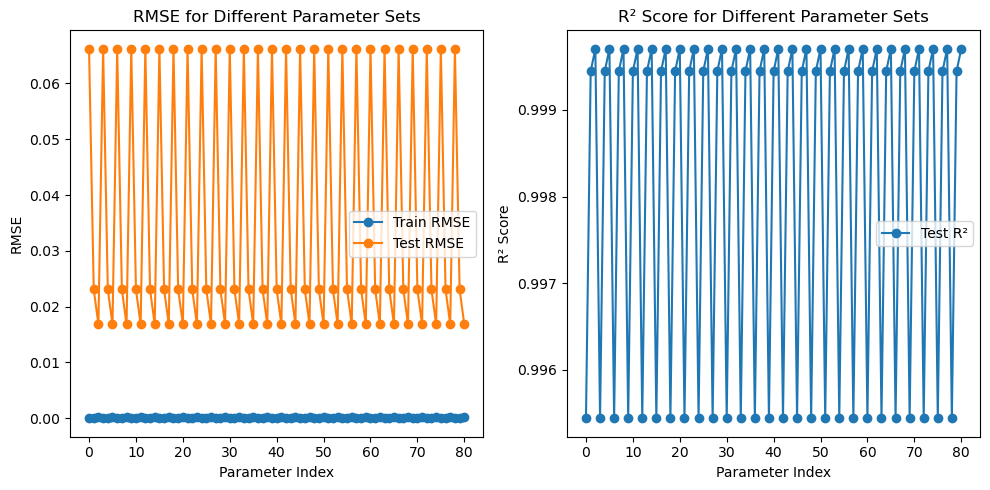

In [28]:
##### Overfitting Check #####
###### NEED TO FIX ######

# Check for overfitting
overfitting_detected = False
threshold = 0.10  # 10% difference threshold

for _, mse_train, mse_test, rmse_train, rmse_test, r2 in results:
    if abs(rmse_train - rmse_test) / rmse_train > threshold:
        overfitting_detected = True
        break

# Print whether overfitting is detected
if overfitting_detected:
    print("Overfitting: Yes")
else:
    print("Overfitting: No")

# Visualization
plt.figure(figsize=(10, 5))

# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(results_df['RMSE Train'], label='Train RMSE', marker='o')
plt.plot(results_df['RMSE Test'], label='Test RMSE', marker='o')
plt.xlabel('Parameter Index')
plt.ylabel('RMSE')
plt.title('RMSE for Different Parameter Sets')
plt.legend()

# Plot R² Score
plt.subplot(1, 2, 2)
plt.plot(results_df['R2'], label='Test R²', marker='o')
plt.xlabel('Parameter Index')
plt.ylabel('R² Score')
plt.title('R² Score for Different Parameter Sets')
plt.legend()

plt.tight_layout()
plt.show()

# Kernel Function 3: Rational Quadratic + White

## Range of all parameters
1. length scale = (1e-4, 1e5) or (1e-4, 1e2) or ((1e-4, 1e8) 
2. noise level = (1e-10, 1e1) or (1e-10, 1e2) or  (1e-10, 1e-2)
3. alpha = 1e-09 or 1e-10 or 1e-11

## Use Grid to Find out the best group of parameters

In [17]:
# Define the parameter grid
length_scales_bounds = [(1e-4, 1e5), (1e-4, 1e2), (1e-4, 1e8)]
noise_levels_bounds = [(1e-10, 1e1), (1e-10, 1e2), (1e-10, 1e-2)]
alphas = [1e-9, 1e-10, 1e-11]

# Create a list of all combinations of parameters
param_grid = list(itertools.product(length_scales_bounds, noise_levels_bounds, alphas))

# Function to create and evaluate a GaussianProcessRegressor with given parameters
def evaluate_gpr(params):
    length_scale_bounds, noise_level_bounds, alpha = params
    kernel = RationalQuadratic(length_scale=1.0, alpha=1.0, length_scale_bounds=length_scale_bounds) + WhiteKernel(noise_level=1.0, noise_level_bounds=noise_level_bounds)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=42)
    gpr.fit(x_train, y_train)
    y_pred_train = gpr.predict(x_train)
    y_pred_test = gpr.predict(x_test)
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2 = r2_score(y_test, y_pred_test)
    
    return mse_train, mse_test, rmse_train, rmse_test, r2

# Perform the grid search
results = []
for params in param_grid:
    mse_train, mse_test, rmse_train, rmse_test, r2 = evaluate_gpr(params)
    results.append((params, mse_train, mse_test, rmse_train, rmse_test, r2))

# Find the best parameters
best_params, best_mse_train, best_mse_test, best_rmse_train, best_rmse_test, best_r2 = min(results, key=lambda x: x[2])

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Parameters', 'MSE Train', 'MSE Test', 'RMSE Train', 'RMSE Test', 'R2'])

# Set display precision for more decimal places
pd.set_option("display.precision", 15)

# Display the results
print("Grid Search Results:")
print(results_df)
print("\nBest Parameters:")
print(best_params)
print("Best R2 Score:")
print(f"{best_r2:.15f}")
print("Best RMSE Train, Test:")
print(f"{best_rmse_train:.15f}", f"{best_rmse_test:.15f}")


/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with

KeyboardInterrupt: 

### Best parameters group for Rational Quadratic + White: ((0.0001, 100.0), (1e-10, 10.0), 1e-11)

## Based on the Best parameters group, change the ratio size
### Test size= 0.2, 0.3, 0.4, 0.5, 0.6

In [18]:
# Load the train data
train_data = pd.read_excel(r'training_fixed.xlsx')

name = ['Z', 'N', 'A', 'A^2/3', '(N-Z)/A', 'PF', 'Zeo', 'NEO', 'Delta_Z', 'Delta_N', 'Shell_P', 'Shell_N']

x_train = pd.DataFrame(train_data, columns=name)
y_train = pd.DataFrame(train_data, columns=['MeV'])

# Load extra data
extra_data = pd.read_excel(r'NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx')
x_extra = pd.DataFrame(extra_data, columns=name)
y_extra = pd.DataFrame(extra_data, columns=['MeV'])

# Define different test sizes
test_sizes = [0.2, 0.3, 0.4, 0.5, 0.6]

for test_size in test_sizes:
    print(f"Processing with test size: {test_size}")
    
    # Split the data into training and testing sets
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
        x_train, y_train, test_size=test_size, random_state=100
    )
    
    train_len = len(x_train_split)
    test_len = len(x_test_split)
    
    # Initialize the StandardScaler for input data
    sc_X = StandardScaler()

    # Fit the scaler on the training data
    sc_X.fit(x_train_split)

    # Transform the training, testing, and extra data using the fitted scaler
    x_train_scaled = sc_X.transform(x_train_split)
    x_test_scaled = sc_X.transform(x_test_split)
    x_extra_scaled = sc_X.transform(x_extra)

    # Initialize the StandardScaler for output data
    sc_Y = StandardScaler()

    # Fit the scaler on the training data
    sc_Y.fit(y_train_split)

    # Transform the training, testing, and extra data using the fitted scaler
    y_train_scaled = sc_Y.transform(y_train_split)
    y_test_scaled = sc_Y.transform(y_test_split)
    y_extra_scaled = sc_Y.transform(y_extra)

    # Print the scaling information
    print("Input Data:")
    print("Mean:", sc_X.mean_)
    print("Standard Deviation:", sc_X.scale_)

    print("\nOutput Data:")
    print("Mean:", sc_Y.mean_)
    print("Standard Deviation:", sc_Y.scale_)

    # Model training and analysis
    os.chdir(cwd)
    analyze_name = "GP_Regression"
    if not os.path.exists(f"./{analyze_name}"):
        os.makedirs(f"./{analyze_name}")
    os.chdir(f"./{analyze_name}")
    wfile = open(f"results_{analyze_name}_selected.txt", "a")

    Scale = [1.0]
    Alpha = [1e-10]
    Normalize = [False]

    for s in Scale:
        for a in Alpha:
            for n in Normalize:
                wfile.write(f"{analyze_name}\n")
                wfile.write(f"Scale : {s} Alpha: {a} Normalize: {n} Test Size: {test_size}\n")
                wfile.write("----------------------------------\n")
            
                kernel = 1.0 * RationalQuadratic(length_scale=s, length_scale_bounds=(0.0001, 100.0), alpha=1e-11) + \
                         WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 10.0))
                gpr = GaussianProcessRegressor(kernel=kernel, alpha=a, normalize_y=n).fit(x_train_scaled, y_train_scaled)

                score = gpr.score(x_train_scaled, y_train_scaled)
                print("R^2 Score:", score)

                pred_train = gpr.predict(x_train_scaled).reshape(-1, 1)
                pred = gpr.predict(x_test_scaled).reshape(-1, 1)
                pred_extra = gpr.predict(x_extra_scaled).reshape(-1, 1)

                pred_train_mean, pred_train_std = gpr.predict(x_train_scaled, return_std=True)
                pred_mean, pred_std = gpr.predict(x_test_scaled, return_std=True)
                pred_extra_mean, pred_extra_std = gpr.predict(x_extra_scaled, return_std=True)

                data_train = np.concatenate((sc_X.inverse_transform(x_train_scaled), sc_Y.inverse_transform(y_train_scaled), sc_Y.inverse_transform(pred_train)), axis=1)
                dfw_train = pd.DataFrame(data_train)
                dfw_train.to_excel('Train_data_predictions.xlsx', index=False, header=name + ['original', 'prediction'])
            
                data_test = np.concatenate((sc_X.inverse_transform(x_test_scaled), sc_Y.inverse_transform(y_test_scaled), sc_Y.inverse_transform(pred)), axis=1)
                dfw_test = pd.DataFrame(data_test)
                dfw_test.to_excel('predictions.xlsx', index=False, header=name + ['original', 'prediction'])
            
                data_extra = np.concatenate((sc_X.inverse_transform(x_extra_scaled), sc_Y.inverse_transform(y_extra_scaled), sc_Y.inverse_transform(pred_extra)), axis=1)
                dfw_extra = pd.DataFrame(data_extra)
                dfw_extra.to_excel('extrapolation.xlsx', index=False, header=name + ['original', 'prediction'])
            
                mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train_scaled) - sc_Y.inverse_transform(pred_train))) / np.size(y_train_scaled)
                rmse_train = np.sqrt(mse_train)

                mse = np.sum(np.square(sc_Y.inverse_transform(y_test_scaled) - sc_Y.inverse_transform(pred))) / np.size(y_test_scaled)
                rmse = np.sqrt(mse)

                ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra_scaled) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra_scaled)
                rms_extra = np.sqrt(ms_extra)

                wfile.write(f"rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n" % (rmse_train, rmse, rms_extra))
                print(rmse_train, rmse, rms_extra)

    wfile.close()
    os.chdir(cwd)


Processing with test size: 0.2
Input Data:
Mean: [ 57.1975891   79.77777778 136.97536688  25.86887333   0.15163836
   3.02816209   0.471174     0.49161426   6.27410901   8.92138365
   1.63259958   2.24737945]
Standard Deviation: [24.55826201 37.92052664 62.07984918  8.4124406   0.07330345  2.39882469
  0.49916837  0.49992967  4.59671523  6.55112964  0.95590746  1.18455223]

Output Data:
Mean: [-40.42893003]
Standard Deviation: [42.04066295]
R^2 Score: 0.9999981826545487
0.05667457864907512 0.5435662680891443 nan
Processing with test size: 0.3
Input Data:
Mean: [ 57.48323353  80.18682635 137.67005988  25.96152917   0.15161144
   3.05355524   0.46886228   0.48742515   6.31556886   8.97005988
   1.64371257   2.26047904]
Standard Deviation: [24.55716819 37.9156305  62.07075933  8.40644008  0.0733222   2.38977257
  0.4990295   0.49984185  4.5830131   6.53257627  0.95434995  1.18212526]

Output Data:
Mean: [-40.08641801]
Standard Deviation: [42.13144207]
R^2 Score: 0.9998529808297838
0.51084

Overfitting: Yes


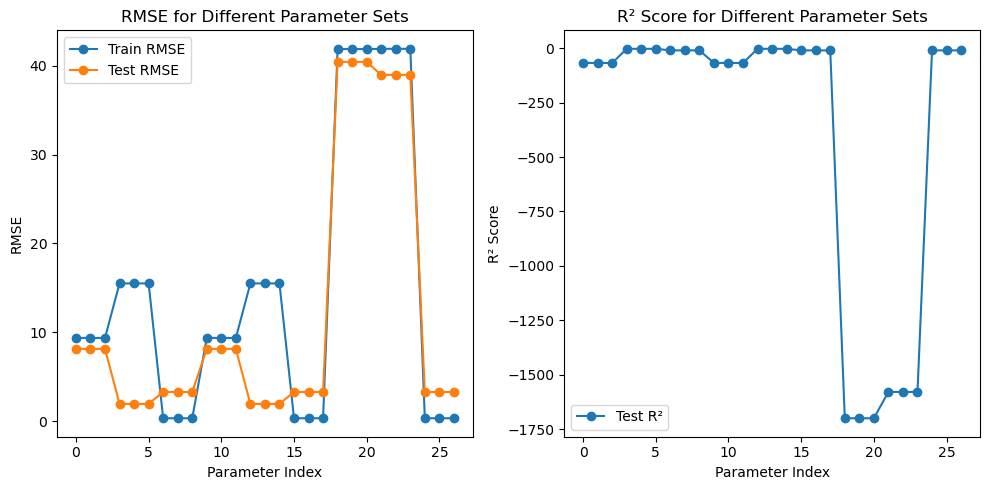

In [19]:
##### Overfitting Check #####
###### NEED TO FIX ######

# Check for overfitting
overfitting_detected = False
threshold = 0.10  # 10% difference threshold

for _, mse_train, mse_test, rmse_train, rmse_test, r2 in results:
    if abs(rmse_train - rmse_test) / rmse_train > threshold:
        overfitting_detected = True
        break

# Print whether overfitting is detected
if overfitting_detected:
    print("Overfitting: Yes")
else:
    print("Overfitting: No")

# Visualization
plt.figure(figsize=(10, 5))

# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(results_df['RMSE Train'], label='Train RMSE', marker='o')
plt.plot(results_df['RMSE Test'], label='Test RMSE', marker='o')
plt.xlabel('Parameter Index')
plt.ylabel('RMSE')
plt.title('RMSE for Different Parameter Sets')
plt.legend()

# Plot R² Score
plt.subplot(1, 2, 2)
plt.plot(results_df['R2'], label='Test R²', marker='o')
plt.xlabel('Parameter Index')
plt.ylabel('R² Score')
plt.title('R² Score for Different Parameter Sets')
plt.legend()

plt.tight_layout()
plt.show()